In [1]:
import tensorflow as tf
import time,sys,os,math,random,itertools,glob,cv2
from datetime import timedelta
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split,ShuffleSplit
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
#get_ipython().run_line_magic('matplotlib', 'inline')
set_random_seed(2)
#final_project_path = r"M:\Course stuff\Fall 17\CMPS 242\final project"
#os.chdir(final_project_path)



def drawProgressBar(percent, barLen = 50):
	sys.stdout.write("\r")
	progress = ""
	for i in range(barLen):
		if i<int(barLen * percent):
			progress += "="
		else:
			progress += " "
	sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
	sys.stdout.flush()



imp_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
def load_train(train_path):
	images = []
	classes = []
	path = train_path
	file_names = os.listdir(os.path.join(os.getcwd(),train_path))
	counter = 1
	print("Creating Classes, reading images and breaking things ...\n")
	for file in file_names:
		drawProgressBar(counter/len(file_names))
		#print(file)
		classes.append(file.split("_")[0])
		image = cv2.imread(os.path.join(os.getcwd(),train_path,file))
		image = image.astype(np.float32)
		image = np.multiply(image, 1.0/255.0) #normalizing the pixel intensities
		images.append(image)
		counter += 1
	print("\nDone!")
	images = np.array(images)
	#classes now has all the labels. order preserved
	#but we need the classes to be floats/ints so lets map the shit out of them
	for i in range(len(classes)):
		if classes[i] not in imp_labels:
			classes[i] = 'unkown'
	d = {ni:indi for indi, ni in enumerate(set(classes))}
	classes = [d[ni] for ni in classes]
	classes = np.array(classes)
	n_values = np.max(classes)+1
	classes = np.eye(n_values)[classes]
	#classes = np.eye(n_values)[classes.reshape(-1)]
	print("\nDone!")
	print("\n images shape: {}, labels shape: {}".format(images.shape,classes.shape))
	return (images,classes)#(train_x,train_y,test_x,test_y)
	

def split_data(images, labels,test_size = 0.2, random_state = 7, shuffle = False):
	return(train_test_split(images,labels,test_size = test_size,random_state = random_state,shuffle = shuffle))


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

	m = X.shape[0]                  # number of training examples
	mini_batches = []
	np.random.seed(seed)
	
	# Step 1: Shuffle (X, Y)
	permutation = list(np.random.permutation(m))
	shuffled_X = X[permutation,:,:,:]
	shuffled_Y = Y[permutation,:]

	# Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
	num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
	for k in range(0, num_complete_minibatches):
		mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
		mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
		mini_batch = (mini_batch_X, mini_batch_Y)
		mini_batches.append(mini_batch)
	
	# Handling the end case (last mini-batch < mini_batch_size)
	if m % mini_batch_size != 0:
		mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
		mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
		mini_batch = (mini_batch_X, mini_batch_Y)
		mini_batches.append(mini_batch)
	
	return mini_batches


def create_placeholders(n_H0, n_W0, n_C0, n_y):

	X = tf.placeholder(shape = [None, n_H0, n_W0, n_C0],dtype = tf.float32)
	Y = tf.placeholder(shape = [None, n_y],dtype = tf.float32)

	return X, Y


def initialize_parameters():

	tf.set_random_seed(1)                              # so that your "random" numbers match ours
		

	W1 = tf.get_variable("W1",[7, 7, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
	W2 = tf.get_variable("W2",[5, 5, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
	W3 = tf.get_variable("W3",[3, 3, 16, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
	W4 = tf.get_variable("W4",[2, 2, 8, 4], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
	W5 = tf.get_variable("W5",[2, 2, 4, 4], initializer = tf.contrib.layers.xavier_initializer(seed = 0))


	parameters = {"W1": W1,
				  "W2": W2,
				  "W3":W3,
				  "W4":W4,
				  "W5":W5}
	
	return parameters

def forward_propagation(X, parameters):

	W1 = parameters['W1']
	W2 = parameters['W2']
	W3 = parameters['W3']
	W4 = parameters['W4']
	W5 = parameters['W5']
	with tf.device('/device:GPU:0'):

		Z1 = tf.nn.conv2d(X,W1,strides = [1,2,2,1], padding = 'SAME')
		A1 = tf.nn.elu(Z1)		
		P1 = tf.nn.max_pool(A1,ksize = [1, 8, 8,1], strides = [1,8,8,1],padding = 'SAME')
		

		Z2 = tf.nn.conv2d(P1, W2, strides=[1,2,2, 1], padding='SAME')
		A2 = tf.nn.elu(Z2)#relu(Z2)
		P2 = tf.nn.max_pool(A2, ksize = [1, 4,4,1], strides = [1, 2,2, 1], padding='SAME')
		
		Z3 = tf.nn.conv2d(P2, W3, strides=[1, 1, 1, 1], padding='SAME')
		A3 = tf.nn.elu(Z3)
		P3 = tf.nn.max_pool(A3, ksize = [1, 2,2, 1], strides = [1, 2,2, 1], padding='SAME')

		#W4
		Z4 = tf.nn.conv2d(P3, W4, strides=[1, 2, 2, 1], padding='SAME')
		A4 = tf.nn.elu(Z4)
		P4 = tf.nn.max_pool(A4, ksize = [1, 4,4, 1], strides = [1, 2,2, 1], padding='SAME')

		#W5
		Z5 = tf.nn.conv2d(P4, W5, strides=[1,2, 2, 1], padding='SAME')
		A5 = tf.nn.elu(Z5)
		P5 = tf.nn.max_pool(A5, ksize = [1, 2,2, 1], strides = [1, 2,2, 1], padding='SAME')
		
		# FLATTEN
		P = tf.contrib.layers.flatten(P5)
		Z6 = tf.contrib.layers.fully_connected(P, 12, activation_fn=None)
		Z7 = tf.contrib.layers.fully_connected(Z6, 12, activation_fn=None)

	return Z7

In [2]:
#saver = tf.train.Saver()
def model(X_train, Y_train, X_test, Y_test,learning_rate=0.009,
		  num_epochs=100, minibatch_size=64, print_cost=True, large_files = False, VAT = False):

	tf.reset_default_graph()
	print("Batch Size : {}\nEpochs: {}\nLearning Rate: {}\nVAT: {}\nLarge_Files: {} ".format(minibatch_size,num_epochs,learning_rate,VAT,large_files))
	title = "elu activations lr "+ str(learning_rate)+" mbs "+str(minibatch_size)+" e "+str(num_epochs)
	if large_files:
		title = "large images"+str(title)
	if VAT:
		title = "VAT "+str(title)
	ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
	tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
	seed = 3                                          # to keep results consistent (numpy seed)
	(m, n_H0, n_W0, n_C0) = X_train.shape             
	n_y = Y_train.shape[1]                            
	costs = []                                        # To keep track of the cost
	
	# Create Placeholders of the correct shape
	X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

	# Initialize parameters
	parameters = initialize_parameters()
	
	# Forward propagation: Build the forward propagation in the tensorflow graph
	Z7 = forward_propagation(X, parameters)
	
	# Cost function: Add cost function to tensorflow graph
	#cost = compute_cost(Z3, Y)
	cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z7, labels = Y))
	with tf.name_scope('Optimizer'):
	# Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
		optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
	
	#saver = tf.train.Saver()
	#summary_op = tf.summary.merge_all()
	config = tf.ConfigProto(allow_soft_placement = True,log_device_placement = False)
	config.gpu_options.allow_growth = True
	sess = tf.Session(config = config)
	init = tf.global_variables_initializer()
	merged = tf.summary.merge([tf.summary.scalar('cross_entropy', cost)])
	#writer = tf.summary.FileWriter(os.path.join(os.getcwd(),"logs"), graph=sess.graph)
	with sess.as_default():
		#saver.restore(sess,str(title)+".ckpt")
		sess.run(init)
		# Do the training loop
		
		for epoch in range(num_epochs+1):
			start = time.time()
			minibatch_cost = 0.
			num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
			batch_count = int(m/minibatch_size)
			seed = seed + 1
			minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
			#c = 0
			for minibatch in minibatches:
				(minibatch_X, minibatch_Y) = minibatch
				_ , temp_cost,summary= sess.run([optimizer, cost,merged], feed_dict={X:minibatch_X, Y:minibatch_Y})
				
				#c += 1
				minibatch_cost += temp_cost / num_minibatches
			#print(type(summary))
			end = time.time()
			if minibatch_cost <= 0.36:
				print("\n == end of training at epoch: {} with cost: {} ==".format(epoch,minibatch_cost))
				break;
			#writer.add_summary(summary, epoch)
			if print_cost == False:
				drawProgressBar(epoch/num_epochs,barLen = 50)
			# Print the cost every epoch
			if print_cost == True: 
				if num_epochs<100 and epoch % 2 == 0:
					print ("Cost after epoch {}: {}".format(epoch, minibatch_cost))
				elif num_epochs<1000:
					if epoch % 10 == 0:
					#end = time.time()
						print ("Cost after epoch {}: {}".format(epoch, minibatch_cost))
				elif num_epochs >= 1000:
					if epoch % 50 == 0:
						print("Cost after epoch {}:{}".format(epoch,minibatch_cost))
			if print_cost == True and epoch % 1 == 0:
				costs.append(minibatch_cost)
		
		#with open(str(title)+".txt","w") as f:
			#for i in range(len(costs)):
				#f.write(str(costs[i]))
				#f.write("\n")
		# plot the cost
		plt.figure(figsize = (5,5))
		plt.plot(np.squeeze(costs))
		plt.ylabel('cost')
		plt.xlabel('iterations (per tens)')
		plt.title(str(title))#"Learning rate =" + str(learning_rate))
		plt.savefig((title)+".png")
		plt.show()
		with tf.device('/device:GPU:0'):
			# Calculate the correct predictions
			predict_op = tf.argmax(Z7, 1)
			correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

			# Calculate accuracy on the test set
			accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
			print(accuracy)
			train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
			test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
		print("Train Accuracy:", train_accuracy)
		print("Test Accuracy:", test_accuracy)
		#saver.save(sess,str(title)+".ckpt")
		print("Saved Model at : {}.ckpt".format(str(title)))
		return train_accuracy, test_accuracy, parameters

Training without VAT
Creating Classes, reading images and breaking things ...

[ ================================================== ] 100.00%
Done!

Done!

 images shape: (64727, 28, 28, 3), labels shape: (64727, 12)
(51781, 28, 28, 3) (12946, 28, 28, 3) (51781, 12) (12946, 12)
Batch Size : 1024
Epochs: 5000
Learning Rate: 0.001
VAT: False
Large_Files: False 
Cost after epoch 0:2.301846129894256
Cost after epoch 50:0.9748922967910766
Cost after epoch 100:0.8052560436725616
Cost after epoch 150:0.7367692494392396
Cost after epoch 200:0.625106656551361
Cost after epoch 250:0.579379861354828
Cost after epoch 300:0.5580554664134979
Cost after epoch 350:0.535738506913185
Cost after epoch 400:0.5209647744894028
Cost after epoch 450:0.5062491995096208
Cost after epoch 500:0.4963218581676484
Cost after epoch 550:0.48585680365562434
Cost after epoch 600:0.4789100354909896
Cost after epoch 650:0.47274056851863866
Cost after epoch 700:0.4682585716247558
Cost after epoch 750:0.46828377068042754
Co

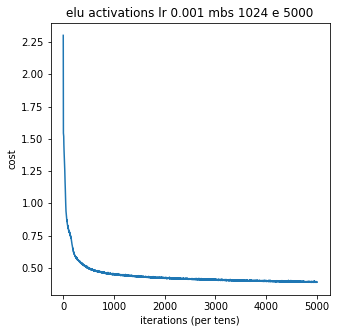

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.877098
Test Accuracy: 0.86575
Saved Model at : elu activations lr 0.001 mbs 1024 e 5000.ckpt
Creating Classes, reading images and breaking things ...

[ ================================================== ] 100.00%
Done!

Done!

 images shape: (64727, 28, 28, 3), labels shape: (64727, 12)
(51781, 28, 28, 3) (12946, 28, 28, 3) (51781, 12) (12946, 12)
Batch Size : 1024
Epochs: 5000
Learning Rate: 0.001
VAT: False
Large_Files: True 
Cost after epoch 0:2.3018461275100703
Cost after epoch 50:0.9740914690494539
Cost after epoch 100:0.805042268037796
Cost after epoch 150:0.7365570783615114
Cost after epoch 200:0.6244137036800385
Cost after epoch 250:0.5750450253486632
Cost after epoch 300:0.5533583784103393
Cost after epoch 350:0.5304897981882094
Cost after epoch 400:0.5153659802675247
Cost after epoch 450:0.5014945060014725
Cost after epoch 500:0.49238498926162727
Cost after epoch 550:0.4822921866178513
Cost a

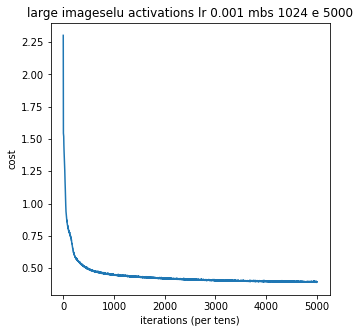

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.878353
Test Accuracy: 0.867295
Saved Model at : large imageselu activations lr 0.001 mbs 1024 e 5000.ckpt
Total time taken = 0 hours, 50 minutes and 35.9484 seconds
Beginning VAT
Creating Classes, reading images and breaking things ...

[ ================================================== ] 100.00%
Done!

Done!

 images shape: (64727, 28, 28, 3), labels shape: (64727, 12)
(51781, 28, 28, 3) (12946, 28, 28, 3) (51781, 12) (12946, 12)
train_x3: (103562, 28, 28, 3)
train_y3: (103562, 12)
test_x.shape: (12946, 28, 28, 3)
test_y.shape: (12946, 12)
Batch Size : 1024
Epochs: 5000
Learning Rate: 0.001
VAT: True
Large_Files: False 
Cost after epoch 0:1.9863636481879956
Cost after epoch 50:0.7743765640966962
Cost after epoch 100:0.6042243903226191
Cost after epoch 150:0.5314740553350731
Cost after epoch 200:0.4990882947303282
Cost after epoch 250:0.4816551869458492
Cost after epoch 300:0.4708080687145196
Cost aft

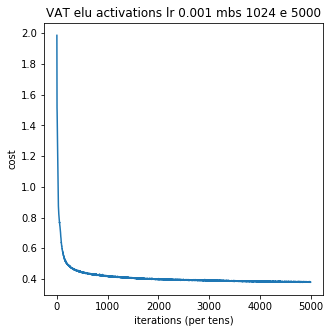

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.719849
Test Accuracy: 0.868531
Saved Model at : VAT elu activations lr 0.001 mbs 1024 e 5000.ckpt



vat large files


Creating Classes, reading images and breaking things ...

[ ================================================== ] 100.00%
Done!

Done!

 images shape: (64727, 28, 28, 3), labels shape: (64727, 12)
(51781, 28, 28, 3) (12946, 28, 28, 3) (51781, 12) (12946, 12)
train_x3: (103562, 28, 28, 3)
train_y3: (103562, 12)
test_x.shape: (12946, 28, 28, 3)
test_y.shape: (12946, 12)
Batch Size : 1024
Epochs: 5000
Learning Rate: 0.001
VAT: True
Large_Files: True 
Cost after epoch 0:1.9863693206617148
Cost after epoch 50:0.7765667898820179
Cost after epoch 100:0.6037771389035895
Cost after epoch 150:0.5351402488085304
Cost after epoch 200:0.5015666918589338
Cost after epoch 250:0.48211624244652174
Cost after epoch 300:0.4698003725250169
Cost after epoch 350:0.46040383630459836
Cost after epoch 400:0.4573

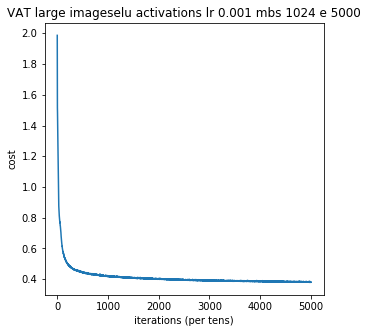

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.718285
Test Accuracy: 0.860188
Saved Model at : VAT large imageselu activations lr 0.001 mbs 1024 e 5000.ckpt
Total time taken = 2 hours, 29 minutes and 55.3722 seconds


In [3]:
print("=====================")
print("Training without VAT")
print("=====================")
images,labels = load_train("im_train")
train_x,test_x,train_y,test_y = split_data(images,labels, test_size = 0.2, shuffle = True)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

#print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))
start = time.time()
_,_, params_vat_large = model(train_x,train_y,test_x,test_y,VAT = False, large_files = False
                              ,learning_rate = 0.001, num_epochs = 5000, minibatch_size = 1024, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60

images,labels = load_train("im_train_large")
train_x,test_x,train_y,test_y = split_data(images,labels, test_size = 0.2, shuffle = True)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
#print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))
start = time.time()
_,_, params_vat_large = model(train_x,train_y,test_x,test_y,VAT = False, large_files = True
                              ,learning_rate = 0.001, num_epochs = 5000, minibatch_size = 1024, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60
print("Total time taken = %i hours, %i minutes and %.4f seconds"%(hrs,mins, secs))


print("=====================")
print("Beginning VAT")
print("=====================")
images,labels = load_train("im_train")
train_x,test_x,train_y,test_y = split_data(images,labels, test_size = 0.2, shuffle = True)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x2 = np.add(np.random.randn(train_x.shape[0],train_x.shape[1],train_x.shape[2],train_x.shape[3])*np.std(train_x)*0.01,train_x)
train_y2 = train_y
train_y3 = np.append(train_y,train_y2, axis = 0)
train_x3 = np.append(train_x,train_x2,axis = 0)
print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))
start = time.time()
_,_, params_vat_large = model(train_x3,train_y3,test_x,test_y,VAT = True, large_files = False
                              ,learning_rate = 0.001, num_epochs = 5000, minibatch_size = 1024, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60
print("\n\n\nvat large files\n\n")
images,labels = load_train("im_train_large")
train_x,test_x,train_y,test_y = split_data(images,labels, test_size = 0.2, shuffle = True)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x2 = np.add(np.random.randn(train_x.shape[0],train_x.shape[1],
                                  train_x.shape[2],train_x.shape[3])*np.std(train_x)*0.01,train_x)
train_y2 = train_y
train_y3 = np.append(train_y,train_y2, axis = 0)
train_x3 = np.append(train_x,train_x2,axis = 0)
print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))
start = time.time()
_,_, params_vat_large = model(train_x3,train_y3,test_x,test_y,VAT = True, large_files = True
                              ,learning_rate = 0.001, num_epochs = 5000, minibatch_size = 1024, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60
print("Total time taken = %i hours, %i minutes and %.4f seconds"%(hrs,mins, secs))

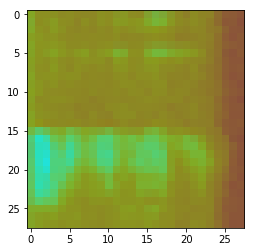

In [4]:
plt.imshow(train_x[12])

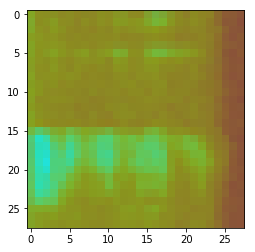

In [8]:
plt.imshow(train_x2[12])

In [9]:
print(train_y[12],train_y2[12])

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


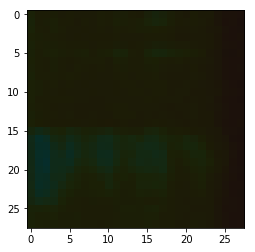

In [11]:
plt.imshow(train_x[12]*np.std(train_x))

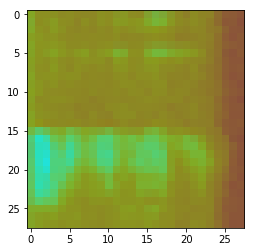

In [16]:
plt.imshow(train_x[12]+(np.std(train_x)*0.0001))

In [7]:
train_x[12] == train_x2[12]

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ..., 
       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ..., 
        [False, False, False],
        [False, False, False],
        [F

train_x3: (103562, 28, 28, 3)
train_y3: (103562, 12)
test_x.shape: (12946, 28, 28, 3)
test_y.shape: (12946, 12)
Batch Size : 64
Epochs: 15
Learning Rate: 0.001  
Cost after epoch 0: 1.538704605568178
Cost after epoch 2: 1.311808852389067
Cost after epoch 4: 1.0748123913377101
Cost after epoch 6: 0.9487186893544479
Cost after epoch 8: 0.8535776111045199
Cost after epoch 10: 0.7927363488284415
Cost after epoch 12: 0.760252226857821
Cost after epoch 14: 0.7288185738957266


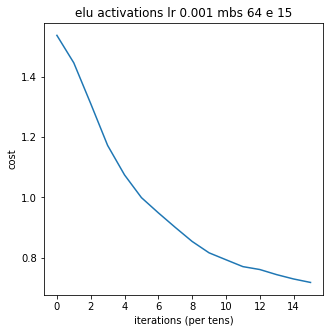

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.774454
Test Accuracy: 0.77437
Saved Model at : elu activations lr 0.001 mbs 64 e 15.ckpt
Batch Size : 1024
Epochs: 5000
Learning Rate: 0.001  
Cost after epoch 0:1.852538996403759
Cost after epoch 50:0.8171113806195778
Cost after epoch 100:0.7109046602013087
Cost after epoch 150:0.6256159585301239
Cost after epoch 200:0.5588534739938114
Cost after epoch 250:0.5184028184059825
Cost after epoch 300:0.4972533554133801
Cost after epoch 350:0.4783316788697006
Cost after epoch 400:0.46687586708824247
Cost after epoch 450:0.45240929073626457
Cost after epoch 500:0.4459702407959665
Cost after epoch 550:0.4370191713961044
Cost after epoch 600:0.43171793222427357
Cost after epoch 650:0.424940568385738
Cost after epoch 700:0.41976610327711206
Cost after epoch 750:0.41764235762086244
Cost after epoch 800:0.41072174139542156
Cost after epoch 850:0.41026092637883566
Cost after epoch 900:0.4035561102451664
Cost after 

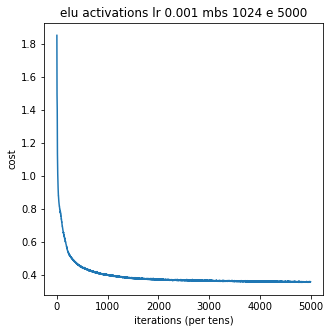

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.716933
Test Accuracy: 0.868376
Saved Model at : elu activations lr 0.001 mbs 1024 e 5000.ckpt
Total time taken = 2 hours, 30 minutes and 5.4029 seconds


In [12]:
train_x2 = np.add(np.random.randn(train_x.shape[0],train_x.shape[1],train_x.shape[2],train_x.shape[3])*np.std(train_x)*0.01,train_x)
train_y2 = train_y
train_y3 = np.append(train_y,train_y2, axis = 0)
train_x3 = np.append(train_x,train_x2,axis = 0)

#print("testing on non VAT:")
#title = "temp"
print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))


_,_,_ = model(train_x,train_y,test_x,test_y, learning_rate = 0.001, num_epochs = 15 , minibatch_size = 64 , print_cost = True)

#print("lr009  batch_size 32 100 epochs")
#title = "lr 0009 e 100 mbs 2048"
#_,_,_ = model(train_x3,train_y3,test_x,test_y, learning_rate = 0.009,num_epochs = 100,minibatch_size = 64, print_cost = True)

#print("lr 0009 mbs e 1000 2048")

start = time.time()
#_, _, parameters = model(train_x3, train_y3, test_x, test_y,learning_rate=0.009,
#		  num_epochs = 1000, minibatch_size = 64, print_cost=True)
_,_, params = model(train_x3,train_y3,test_x,test_y,learning_rate = 0.001, num_epochs = 5000, minibatch_size = 1024, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60
print("Total time taken = %i hours, %i minutes and %.4f seconds"%(hrs,mins, secs))
#title = "lr 0001 mb 2048 ep 5000 adv training"
#print(title)

Creating Classes, reading images and breaking things ...

[ ================================================== ] 100.00%
Done!

Done!

 images shape: (64727, 28, 28, 3), labels shape: (64727, 12)
(51781, 28, 28, 3) (12946, 28, 28, 3) (51781, 12) (12946, 12)
train_x3: (103562, 28, 28, 3)
train_y3: (103562, 12)
test_x.shape: (12946, 28, 28, 3)
test_y.shape: (12946, 12)
Batch Size : 64
Epochs: 20
Learning Rate: 0.006  
Cost after epoch 0: 1.4328361282537248
Cost after epoch 2: 0.8969597349723871
Cost after epoch 4: 0.7359997292678933
Cost after epoch 6: 0.6447841265366603
Cost after epoch 8: 0.6057856586313954
Cost after epoch 10: 0.5750817176880146
Cost after epoch 12: 0.5619035937324888
Cost after epoch 14: 0.5466762499697272
Cost after epoch 16: 0.5410817606450598
Cost after epoch 18: 0.5342100216778004
Cost after epoch 20: 0.5348337709314309


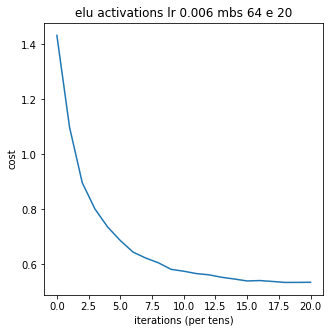

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.817423
Test Accuracy: 0.810907
Saved Model at : elu activations lr 0.006 mbs 64 e 20.ckpt
Batch Size : 64
Epochs: 3000
Learning Rate: 0.009  
Cost after epoch 0:1.214076730041628
Cost after epoch 50:0.517672833621649
Cost after epoch 100:0.5029443152644872
Cost after epoch 150:0.5031872202166822
Cost after epoch 200:0.49492061271692434
Cost after epoch 250:0.49681881143814016
Cost after epoch 300:0.49337301409730866
Cost after epoch 350:0.48941559618976727
Cost after epoch 400:0.4887893892944372
Cost after epoch 450:0.4881149947422251
Cost after epoch 500:0.48052217350865206
Cost after epoch 550:0.4791546670538096
Cost after epoch 600:0.47008518371800095
Cost after epoch 650:0.4723912452235915
Cost after epoch 700:0.47222931690431214
Cost after epoch 750:0.4706222924814822
Cost after epoch 800:0.47282864932518825
Cost after epoch 850:0.46304886661958045
Cost after epoch 900:0.4692803486923802
Cost after

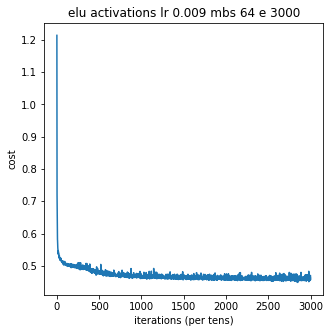

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.703868
Test Accuracy: 0.845126
Saved Model at : elu activations lr 0.009 mbs 64 e 3000.ckpt
Total time taken = 5 hours, 12 minutes and 3.5579 seconds


In [13]:
images,labels = load_train("im_train_large")
train_x,test_x,train_y,test_y = split_data(images,labels, test_size = 0.2, shuffle = True)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x2 = np.add(np.random.randn(train_x.shape[0],train_x.shape[1],train_x.shape[2],train_x.shape[3])*np.std(train_x)*0.01,train_x)
train_y2 = train_y
train_y3 = np.append(train_y,train_y2, axis = 0)
train_x3 = np.append(train_x,train_x2,axis = 0)

#print("testing on non VAT:")
#title = "temp"
print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))


_,_,_ = model(train_x,train_y,test_x,test_y, learning_rate = 0.006, num_epochs = 20 , minibatch_size = 64 , print_cost = True)

#print("lr009  batch_size 32 100 epochs")
#title = "lr 0009 e 100 mbs 2048"
#_,_,_ = model(train_x3,train_y3,test_x,test_y, learning_rate = 0.009,num_epochs = 100,minibatch_size = 64, print_cost = True)

#print("lr 0009 mbs e 1000 2048")

start = time.time()
#_, _, parameters = model(train_x3, train_y3, test_x, test_y,learning_rate=0.009,
#		  num_epochs = 1000, minibatch_size = 64, print_cost=True)
_,_, params = model(train_x3,train_y3,test_x,test_y,learning_rate = 0.009, num_epochs = 3000, minibatch_size = 64, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60
print("Total time taken = %i hours, %i minutes and %.4f seconds"%(hrs,mins, secs))
#title = "lr 0001 mb 2048 ep 5000 adv training"
#print(title)

train_x3: (103562, 28, 28, 3)
train_y3: (103562, 12)
test_x.shape: (12946, 28, 28, 3)
test_y.shape: (12946, 12)



Batch Size : 64
Epochs: 15
Learning Rate: 0.001  
Cost after epoch 0: 1.5387043952941868
Cost after epoch 2: 1.3108156644664388
Cost after epoch 4: 1.0675960644361273
Cost after epoch 6: 0.9431184435951702
Cost after epoch 8: 0.8503288585780143
Cost after epoch 10: 0.7920647936289477
Cost after epoch 12: 0.7582914373193892
Cost after epoch 14: 0.7265116017224321


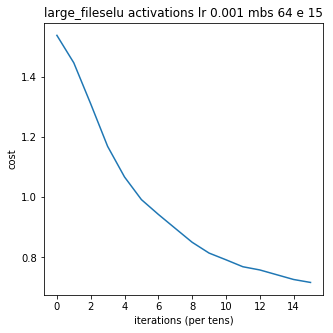

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.774493
Test Accuracy: 0.771821
Saved Model at : elu activations lr 0.001 mbs 64 e 15.ckpt






Batch Size : 1024
Epochs: 5000
Learning Rate: 0.001  
Cost after epoch 0:1.8525937866456443
Cost after epoch 50:0.7944315276523625
Cost after epoch 100:0.6641651663449732
Cost after epoch 150:0.6009879041426256
Cost after epoch 200:0.5680660623134953
Cost after epoch 250:0.5452337896469795
Cost after epoch 300:0.526236864009706
Cost after epoch 350:0.5009702582760612
Cost after epoch 400:0.48959486791403
Cost after epoch 450:0.47548144023017114
Cost after epoch 500:0.465557597061195
Cost after epoch 550:0.4590094328516781
Cost after epoch 600:0.45751005322626326
Cost after epoch 650:0.45044090193096964
Cost after epoch 700:0.44672269632320594
Cost after epoch 750:0.45120323441996435
Cost after epoch 800:0.44180875426471844
Cost after epoch 850:0.43966622370304437
Cost after epoch 900:0.43756849665452946
Cost 

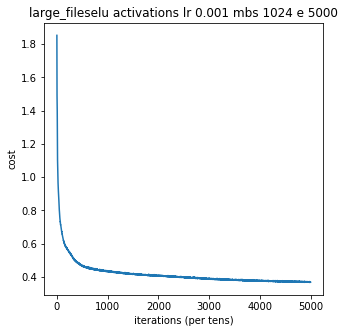

Tensor("Mean_1:0", shape=(), dtype=float32, device=/device:GPU:0)
Train Accuracy: 0.718304
Test Accuracy: 0.869458
Saved Model at : elu activations lr 0.001 mbs 1024 e 5000.ckpt
Total time taken = 2 hours, 30 minutes and 4.7961 seconds


In [15]:
#print("testing on non VAT:")
#title = "temp"
print("train_x3: {}\ntrain_y3: {}\ntest_x.shape: {}\ntest_y.shape: {}\n\n\n".format(train_x3.shape,train_y3.shape,test_x.shape,test_y.shape))


_,_,_ = model(train_x,train_y,test_x,test_y, learning_rate = 0.001, num_epochs = 15 , minibatch_size = 64 , print_cost = True)

#print("lr009  batch_size 32 100 epochs")
#title = "lr 0009 e 100 mbs 2048"
#_,_,_ = model(train_x3,train_y3,test_x,test_y, learning_rate = 0.009,num_epochs = 100,minibatch_size = 64, print_cost = True)

#print("lr 0009 mbs e 1000 2048")
print("\n\n\n\n\n")
start = time.time()
#_, _, parameters = model(train_x3, train_y3, test_x, test_y,learning_rate=0.009,
#		  num_epochs = 1000, minibatch_size = 64, print_cost=True)
_,_, params = model(train_x3,train_y3,test_x,test_y,learning_rate = 0.001, num_epochs = 5000, minibatch_size = 1024, print_cost = True)
total_end = time.time()
hrs = 0
mins = (total_end-start)/60
if mins > 60:
	hrs = mins/60
	mins %= 60
secs = (total_end-start)%60
print("Total time taken = %i hours, %i minutes and %.4f seconds"%(hrs,mins, secs))
#title = "lr 0001 mb 2048 ep 5000 adv training"
#print(title)